In [1]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ananse
from ananse.peakpredictor import PeakPredictor
import networkx as nx
from scipy.stats import wilcoxon
from sklearn.metrics import roc_auc_score, average_precision_score
from adjustText import adjust_text

%matplotlib inline

In [2]:
bench_data = "../data/20210223.benchmark.txt"
df = pd.read_table(bench_data, index_col=0)
df = df.groupby(["factor", "test_cell_type", "model", "score"]).mean().reset_index()

bench_data = "../data/20210223.benchmark.with_general.txt"
df_general = pd.read_table(bench_data, index_col=0)
df_general = df_general.groupby(["factor", "test_cell_type", "model", "score"]).mean().reset_index()

df = pd.concat((df, df_general))

In [3]:
df["model"].unique()

array(['ATAC.baseline', 'ATAC_ATAC.relative_H3K27ac_average_dist_motif',
       'ATAC_ATAC.relative_H3K27ac_motif',
       'ATAC_ATAC.relative_average_dist_motif',
       'ATAC_ATAC.relative_motif', 'ATAC_H3K27ac_motif',
       'ATAC_average_dist_motif', 'ATAC_motif', 'H3K27ac.baseline',
       'H3K27ac_average_dist_motif', 'H3K27ac_motif', 'average.baseline',
       'baseline', 'dist.baseline', 'motif.baseline',
       'ATAC_ATAC.relative_H3K27ac_average_dist_motif.general',
       'ATAC_ATAC.relative_H3K27ac_motif.general',
       'ATAC_ATAC.relative_average_dist_motif.general',
       'ATAC_ATAC.relative_motif.general', 'ATAC_H3K27ac_motif.general',
       'ATAC_average_dist_motif.general', 'ATAC_motif.general',
       'H3K27ac_average_dist_motif.general', 'H3K27ac_motif.general'],
      dtype=object)

In [4]:
map_names = {
    "average.baseline": "Baseline - average ChIP-seq",
    "ATAC_ATAC.relative_H3K27ac_average_dist_motif":"ANANSE (with reference)",
    "ATAC_H3K27ac_motif": "ANANSE (no reference)",
    "ATAC_ATAC.relative_H3K27ac_average_dist_motif.general":"ANANSE (general, with reference)",
    "ATAC_H3K27ac_motif.general": "ANANSE (general, no reference)",
    "baseline": "Baseline - random",
    "ATAC.baseline":"ATAC-seq only",
    "H3K27ac.baseline":"H3K27ac ChIP-seq only",
    "motif.baseline":"Motif only",
}

In [5]:
df = df[df["model"].isin(map_names)]


for k,v in map_names.items():
    df["model"] = df["model"].str.replace(f"^{k}$", v)

'NimbusSans-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


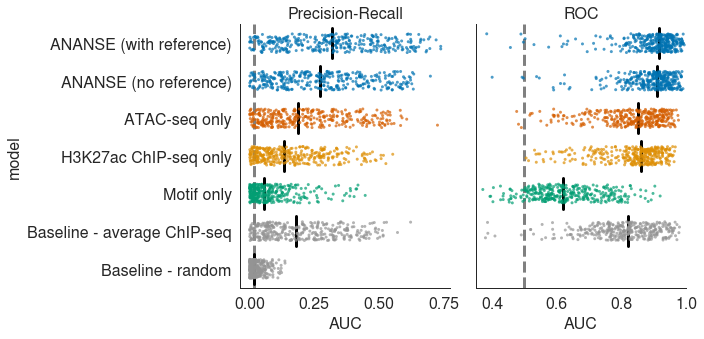

In [6]:
plot_df = df[~df["model"].str.contains("general")]

sns.set_context(
    "paper",
    rc={
        "font.size": 16,
        "axes.titlesize": 16,
        "axes.labelsize": 16,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
    },
)
from matplotlib import rcParams
rcParams['font.family'] = 'Nimbus Sans'

#order = plot_df[plot_df["score"] == "pr_auc"].groupby("model").median()["value"].sort_values().index
order = [
    "Baseline - random",
    "Baseline - average ChIP-seq",
    "Motif only",
    "H3K27ac ChIP-seq only",
    "ATAC-seq only",
    "ANANSE (no reference)",
    "ANANSE (with reference)",
][::-1]

pal = sns.color_palette("colorblind")
my_pal = {
    "Baseline - random":pal[7],
    "Baseline - average ChIP-seq":pal[7],
    "Motif only":pal[2],
    "H3K27ac ChIP-seq only":pal[1],
    "ATAC-seq only":pal[3],
    "ANANSE (no reference)":pal[0],
    "ANANSE (with reference)":pal[0],
}


g = sns.catplot(data=plot_df, x="value", y="model", col="score", kind="strip",jitter=0.25, order=order, s=3, alpha=0.7,  sharex=False,
               palette=my_pal)
g.map(sns.boxplot,
    "value",
    "model",
    color="white",
    fliersize=0,
    order=order,
    boxprops={"edgecolor":"white"},
    whiskerprops={"color":"white"},
    capprops={"color":"white"},
    medianprops={"color":"black", "linewidth":3},
)
g.axes[0][1].set_xlim(0.35,1)
g.axes[0][0].set_xlabel("AUC")
g.axes[0][1].set_xlabel("AUC")
g.axes[0][0].set_title("Precision-Recall")
g.axes[0][1].set_title("ROC")
g.axes[0][0].axvline(plot_df[(plot_df["score"] == "pr_auc")&(plot_df["model"] == "Baseline - random")].median()["value"], ls="--", color="grey", linewidth=3)
g.axes[0][1].axvline(0.5, ls="--", color="grey", linewidth=3)

plt.savefig("fig3a.pdf")


In [7]:
df_pivot = df.pivot(index=["factor", "test_cell_type", "score"], columns=["model"], values=["value"], )["value"].reset_index()

'NimbusSans-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


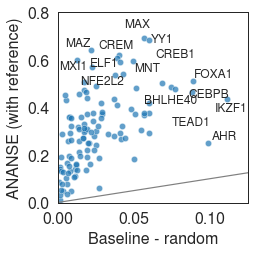

In [8]:
xlabel = "Baseline - random"
ylabel = "ANANSE (with reference)"

plot_data = df_pivot.groupby(["factor", "score"]).median().reset_index()
plt.figure(figsize=(3.5,3.5))
g = sns.scatterplot(xlabel,ylabel, data=plot_data, alpha=.7,s=40 )

plt.plot([0,1], [0,1], color="grey")
    
highlight = pd.concat((
    plot_data.loc[(plot_data[xlabel] - plot_data[ylabel]).sort_values().index].head(10),
    plot_data.loc[plot_data[xlabel].dropna().sort_values().index].tail(5),
), axis=0)

   
texts = []

for i, (tf, x, y) in highlight[["factor",xlabel, ylabel]].iterrows():
    texts.append(plt.text(x, y, tf, {"size": 12}))


plt.xlim(0, 0.125)
plt.ylim(0, 0.8)
g.set_aspect(1./g.get_data_ratio())

adjust_text(
    texts, 
    x=plot_data[xlabel].values,
    y=plot_data[ylabel].values,
)
plt.savefig("fig3b.pdf")

In [9]:
ref = f"{os.path.dirname(ananse.__file__)}/db/default_reference"
p = PeakPredictor(regions=["chr1:1000100-1000300","chr2:1000100-1000300"], atac_bams=["../data/dummy.bam"],
         reference=ref)

2021-05-26 20:29:40.588 | DEBUG    | ananse.peakpredictor:_load_motifs:232 - Using default motif file
2021-05-26 20:29:45.684 | DEBUG    | ananse.peakpredictor:_load_motifs:243 - using motifs for 828 factors
2021-05-26 20:29:47.728 | INFO     | ananse.peakpredictor:_scan_motifs:93 - Scanning regions for motifs.
2021-05-26 20:29:47,731 - INFO - reading table
2021-05-26 20:29:54,663 - INFO - creating score table (z-score, GC%)
2021-05-26 20:30:06,333 - INFO - done
2021-05-26 20:30:08,656 - INFO - creating dataframe
2021-05-26 20:30:09.385 | INFO     | ananse.peakpredictor:load_atac:332 - loading ATAC data
2021-05-26 20:30:09.389 | DEBUG    | ananse.peakpredictor:_load_bams:291 - quantile normalization for ATAC
2021-05-26 20:30:10.978 | INFO     | ananse.peakpredictor:_set_model_type:373 - Loading models
2021-05-26 20:30:11.182 | INFO     | ananse.peakpredictor:_set_model_type:378 - 238 models found


In [10]:
def get_tfs():
    valid_factors = pd.read_excel(
        "https://www.biorxiv.org/content/biorxiv/early/2020/12/07/2020.10.28.359232/DC1/embed/media-1.xlsx",
        engine="openpyxl",
        sheet_name=1,
    )
    valid_factors = valid_factors.loc[
        valid_factors["Pseudogene"].isnull(), "HGNC approved gene symbol"
    ].values
    valid_factors = [f for f in valid_factors if f != "EP300"]
    return valid_factors

human_tfs = get_tfs()
tf_df = pd.DataFrame(index=human_tfs)

In [11]:
tf_df['has_motif'] = tf_df.index.isin(p.f2m)
tf_df['has_model'] = tf_df.index.isin(p.factor_models)

has_related_model = []
related_factor = []
for factor in tf_df[tf_df["has_motif"] & ~tf_df["has_model"]].index:
    paths = {
        path: v
        for path, v in nx.single_source_dijkstra_path_length(
            p.motif_graph, factor
        ).items()
        if path in p.factor_models
    }
    has_related_model.append(len(paths) > 0)
    
    if len(paths) > 0:
        close_factor = sorted(paths, key=lambda x: paths[x])[0]
    else:
        close_factor = None
    related_factor.append(close_factor)

tf_df["has_related_model"] = False
tf_df.loc[tf_df["has_motif"] & ~tf_df["has_model"], "has_related_model"] = has_related_model
tf_df.loc[tf_df["has_motif"] & ~tf_df["has_model"], "related_factor"] = related_factor
tf_df["has_any_model"] = tf_df["has_model"] | tf_df["has_related_model"]

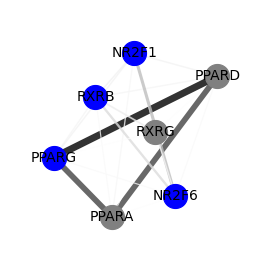

In [12]:
edges = [e for e in p.motif_graph.edges if "PPARG" in e and p.motif_graph[e[0]][e[1]]['weight'] < 0.9]
nodes = list(set([e[0] for e in edges] + [e[1] for e in edges]))

sub_graph = p.motif_graph.subgraph(nodes)
edges
sub_graph.nodes
plt.figure(num=None, figsize=(3, 3), dpi=100)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(sub_graph, k=2)

edges = sub_graph.edges
weights = [(1 - sub_graph[u][v]['weight']) * 5 for u,v in edges]

nx.draw_networkx_nodes(sub_graph.subgraph([node for node in nodes if tf_df.loc[node, "has_model"]]), pos=pos, node_size=300, node_color="blue", )
nx.draw_networkx_nodes(sub_graph.subgraph([node for node in nodes if ~tf_df.loc[node, "has_model"]]), pos=pos, node_size=300, node_color="grey", )
nx.draw_networkx_labels(sub_graph,pos=pos, font_size=10)
nx.draw_networkx_edges(sub_graph,pos=pos,edgelist=edges,edge_color = weights, width=weights, alpha=0.8, edge_cmap=plt.cm.Greys)
axis = plt.gca()
# maybe smaller factors work as well, but 1.1 works fine for this minimal example
axis.set_xlim([1.4*x for x in axis.get_xlim()])
axis.set_ylim([1.4*y for y in axis.get_ylim()])
plt.tight_layout()
plt.savefig("fig3d.pdf", dpi=300)

In [13]:
no_motif = tf_df.shape[0] - tf_df.sum().loc["has_motif"]
motif_and_model = tf_df.sum().loc["has_model"]
motif_and_related_model = tf_df.sum().loc["has_related_model"]
motif_no_model = tf_df.sum().loc["has_motif"] - tf_df.sum().loc["has_any_model"] 

print(f"no motif {no_motif / tf_df.shape[0] * 100:.1f}%", )
print(f"motif_and_model {motif_and_model / tf_df.shape[0] * 100:.1f}%", )
print(f"motif_and_related_model {motif_and_related_model / tf_df.shape[0] * 100:.1f}%", )
print(f"motif_no_model {motif_no_model / tf_df.shape[0] * 100:.1f}%", )




no motif 41.4%
motif_and_model 16.8%
motif_and_related_model 31.7%
motif_no_model 10.2%


'NimbusSans-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


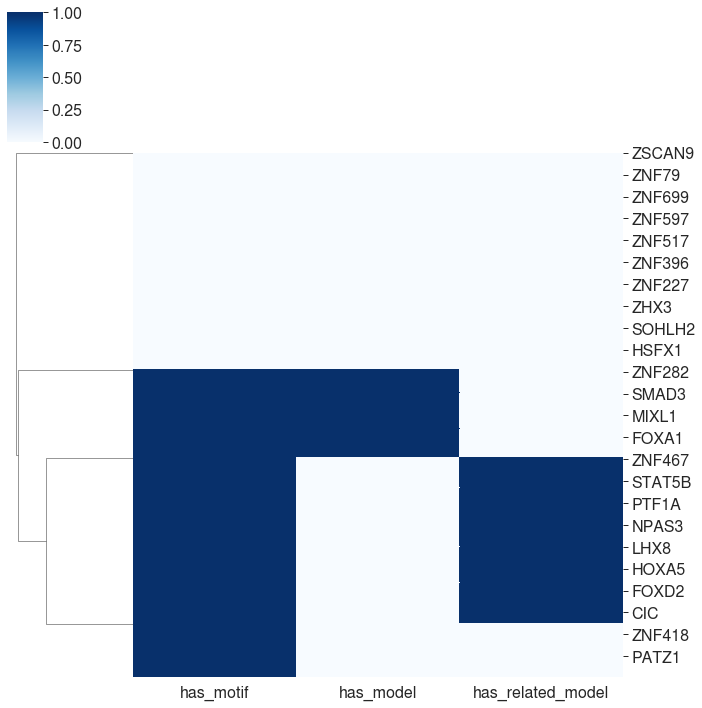

In [14]:
sns.clustermap(tf_df[["has_motif", "has_model", "has_related_model"]], col_cluster=False, cmap="Blues")
plt.savefig("fig3c.pdf", dpi=300)